<a href="https://colab.research.google.com/github/sampriti-mahapatra/customer-churn-prediction/blob/main/Customer_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing data from Kaggle

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sampritimahapatra","key":"61216ffdc0cf23887c6cd5c162dbe774"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d blastchar/telco-customer-churn

Dataset URL: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
License(s): copyright-authors
telco-customer-churn.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip telco-customer-churn.zip -d telco_data

Archive:  telco-customer-churn.zip
replace telco_data/WA_Fn-UseC_-Telco-Customer-Churn.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: no


In [5]:
import os
os.listdir("telco_data")

['WA_Fn-UseC_-Telco-Customer-Churn.csv']

In [6]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

In [7]:
df = pd.read_csv("telco_data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [8]:
print(df.info())  # Displays column data types and missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [9]:
# Check for Duplicates
print(f"Duplicate rows: {df.duplicated().sum()}")

Duplicate rows: 0


In [10]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce") # changing the values in TotalCharges to float type

### Balancing Numerical Columns and Handling Outliers

In [11]:
numerical_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

In [12]:
Q1 = df[numerical_cols].quantile(0.25)  # First quartile (25th percentile)
Q3 = df[numerical_cols].quantile(0.75)  # Third quartile (75th percentile)
IQR = Q3 - Q1  # Interquartile range

# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers = ((df[numerical_cols] < lower_bound) | (df[numerical_cols] > upper_bound)).sum()
print("Number of outliers in each column:\n", outliers)


Number of outliers in each column:
 tenure            0
MonthlyCharges    0
TotalCharges      0
dtype: int64


In [13]:
scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [14]:
df[numerical_cols].describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,0.449599,0.462803,0.261309
std,0.341104,0.299403,0.261571
min,0.000000,0.000000,0.000000
25%,0.125000,0.171642,0.044155
50%,0.402778,0.518408,0.159090
75%,0.763889,0.712438,0.435719
max,1.000000,1.000000,1.000000


### Exploratory Data Analysis

Churn
No     5174
Yes    1869
Name: count, dtype: int64


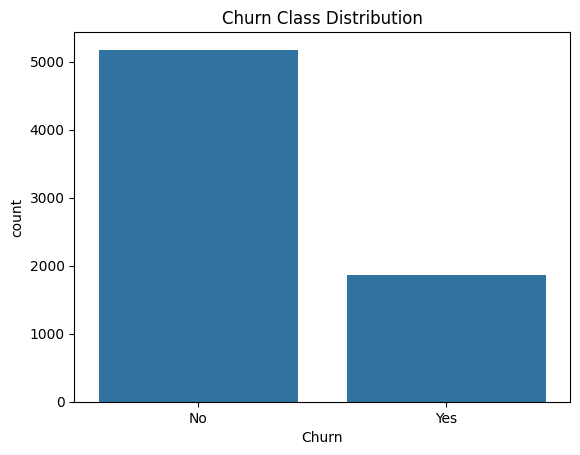

In [15]:
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Check class distribution
print(df["Churn"].value_counts())

# Visualize class distribution
sns.countplot(x=df["Churn"])
plt.title("Churn Class Distribution")
plt.show()


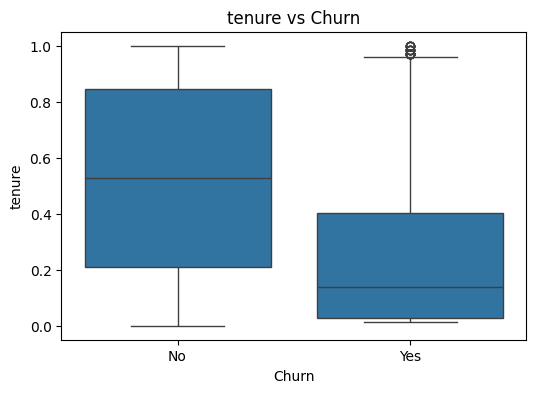

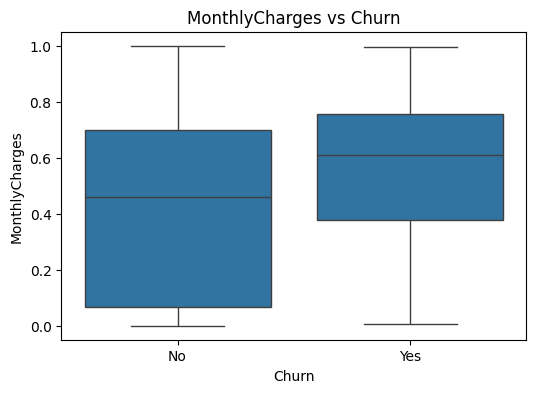

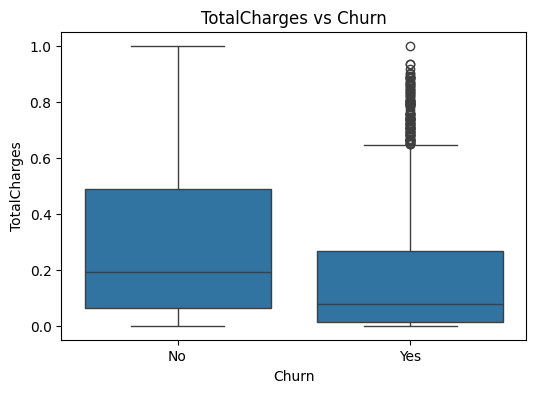

In [16]:
num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="Churn", y=col, data=df)
    plt.title(f"{col} vs Churn")
    plt.show()


- customer churn is less among people who have subscribed for a longer tenure
- churn is higher for people who play higher monthly charges
- lower total charges result in overall customers leaving

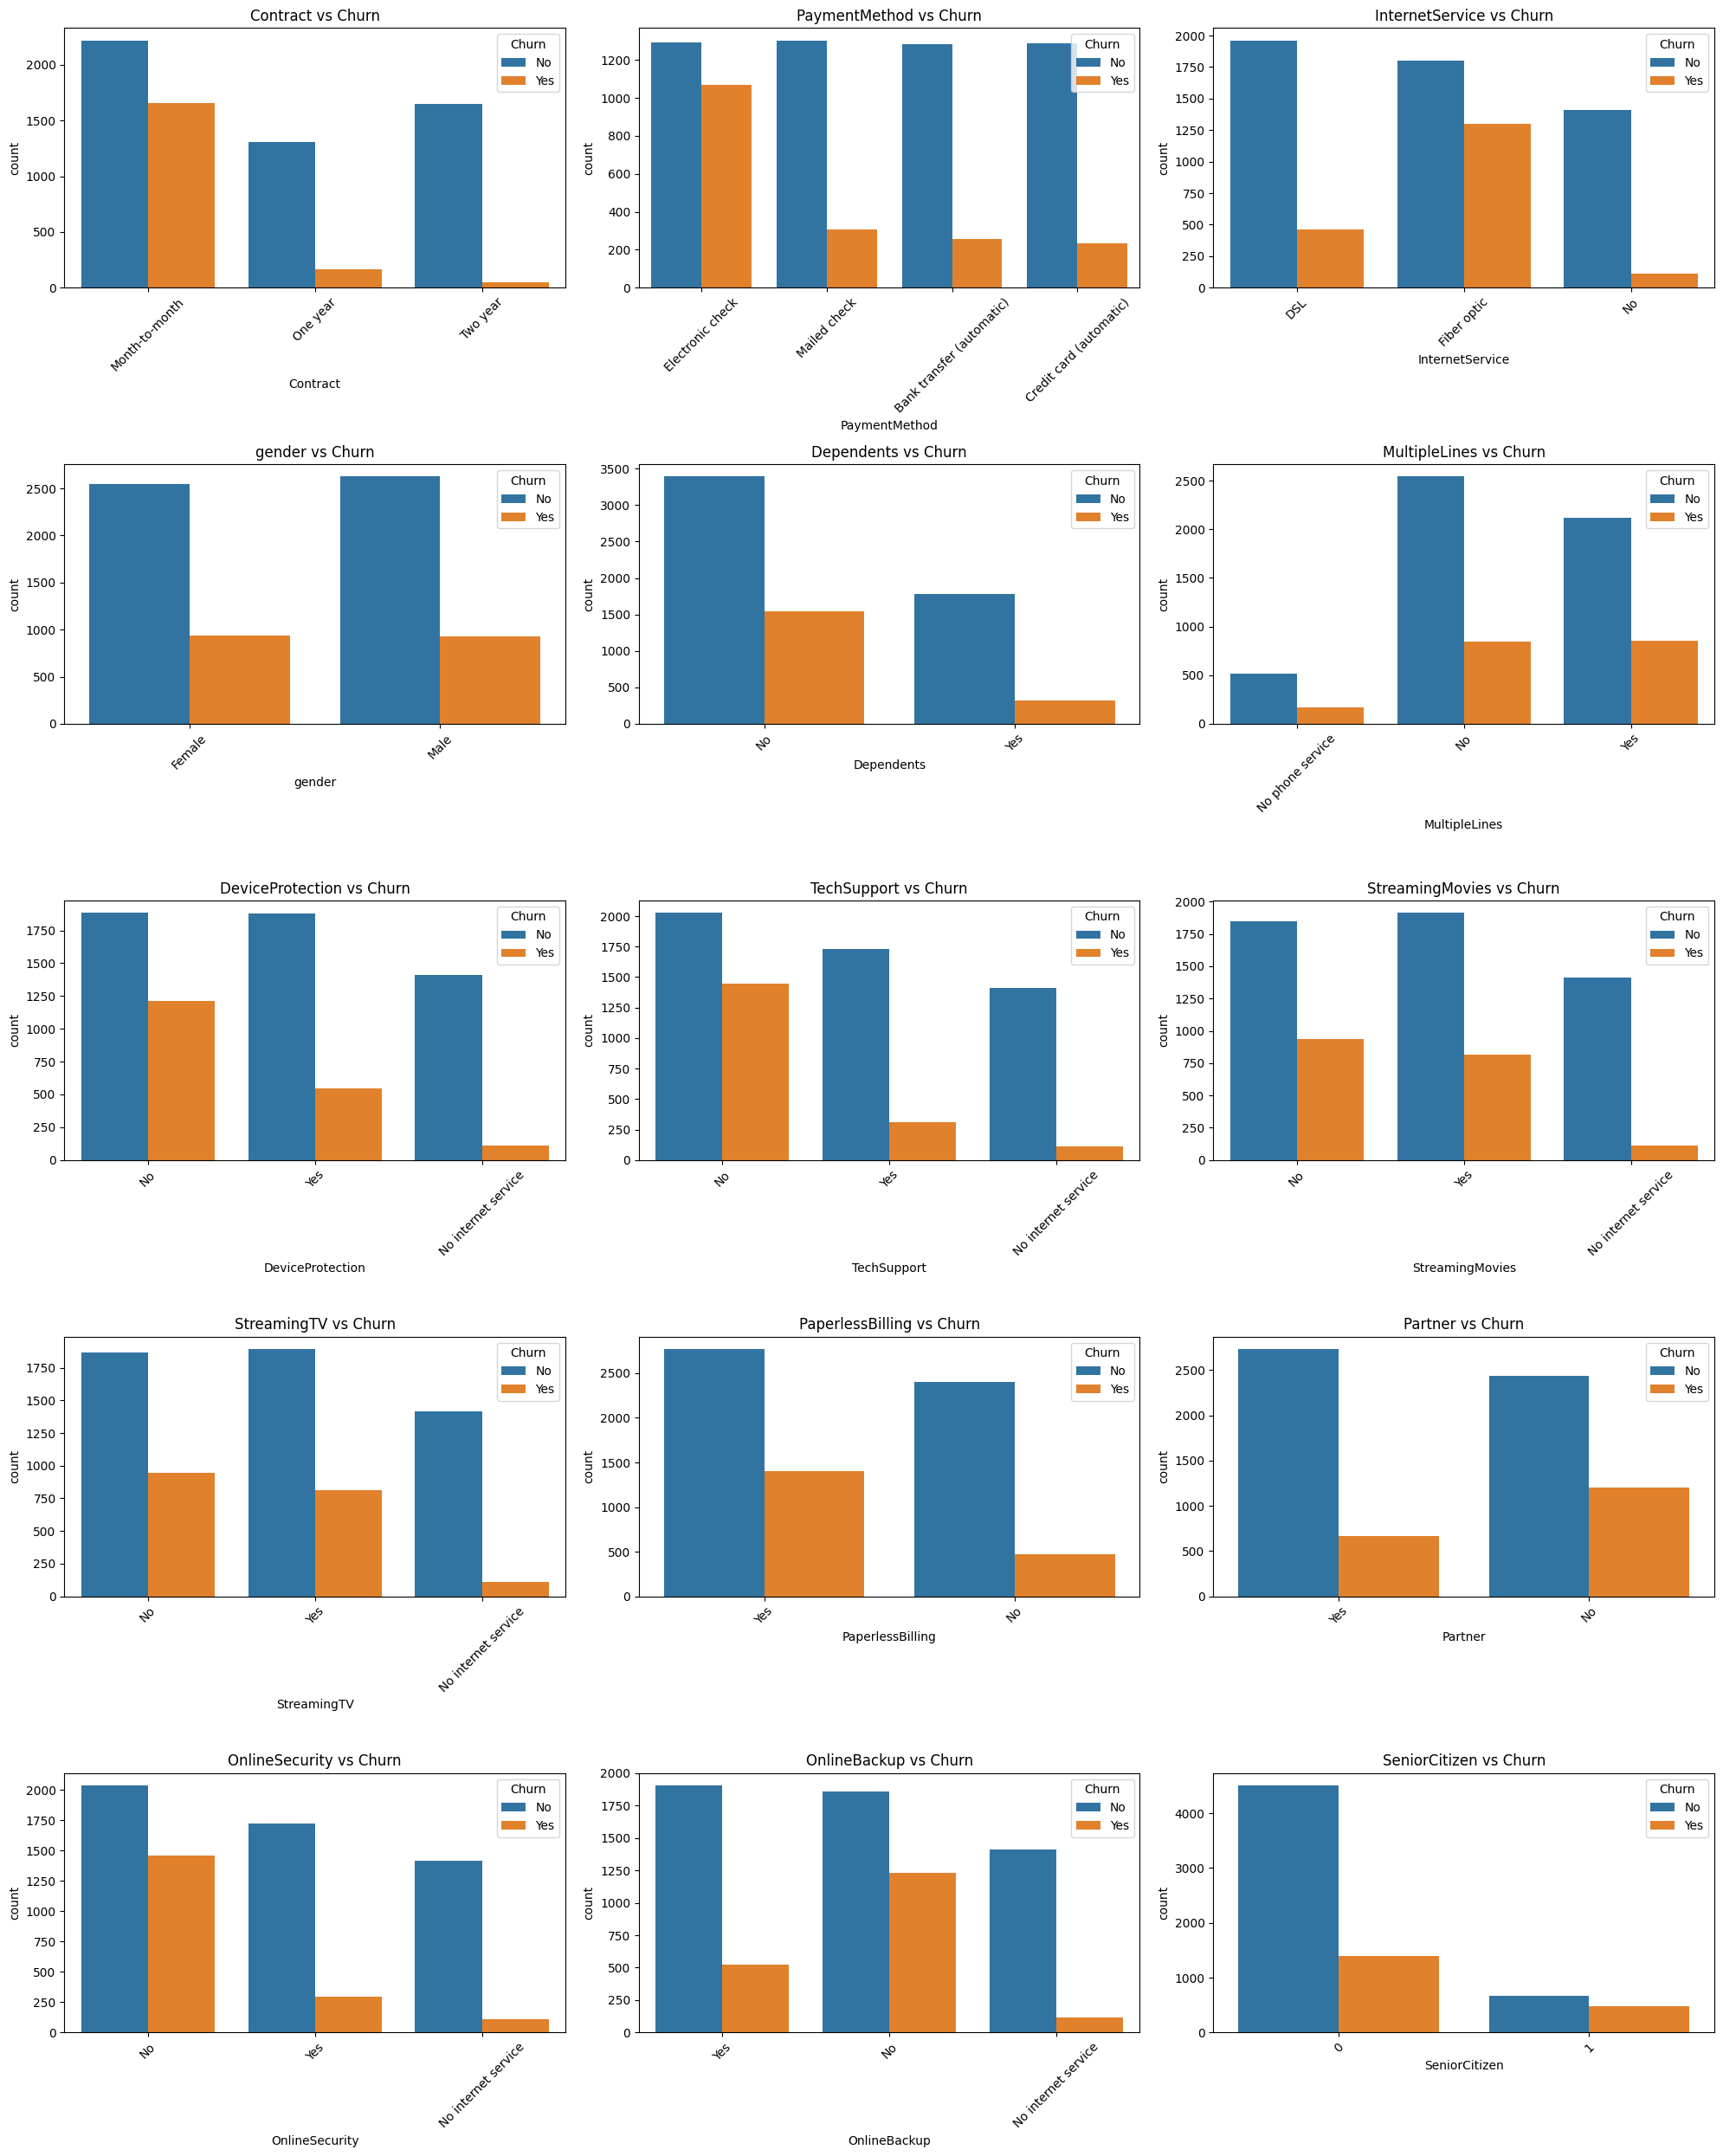

In [17]:
cat_cols = ["Contract", "PaymentMethod", "InternetService", "gender", "Dependents", "MultipleLines",
            "DeviceProtection", "TechSupport", "StreamingMovies", "StreamingTV",
            "PaperlessBilling", "Partner", "OnlineSecurity", "OnlineBackup", "SeniorCitizen"]

# Creating a 5x3 grid for 15 plots
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 25))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(x=col, hue="Churn", data=df, ax=axes[i])
    axes[i].set_title(f"{col} vs Churn")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [18]:
# Encoding categorical variables
categorical_columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
                       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                       'TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod']

for col in categorical_columns:
    df[col], _ = pd.factorize(df[col])

In [19]:
df.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,0,0,0,0,0.013889,0,0,0,0,...,0,0,0,0,0,0,0,0.115423,0.001275,No
1,5575-GNVDE,1,0,1,0,0.472222,1,1,0,1,...,1,0,0,0,1,1,1,0.385075,0.215867,No
2,3668-QPYBK,1,0,1,0,0.027778,1,1,0,1,...,0,0,0,0,0,0,1,0.354229,0.010310,Yes
3,7795-CFOCW,1,0,1,0,0.625000,0,0,0,1,...,1,1,0,0,1,1,2,0.239303,0.210241,No
4,9237-HQITU,0,0,1,0,0.027778,1,1,1,0,...,0,0,0,0,0,0,0,0.521891,0.015330,Yes
5,9305-CDSKC,0,0,1,0,0.111111,1,2,1,0,...,1,0,1,1,0,0,0,0.809950,0.092511,Yes
6,1452-KIOVK,1,0,1,1,0.305556,1,2,1,0,...,0,0,1,0,0,0,3,0.704975,0.222779,No
7,6713-OKOMC,0,0,1,0,0.138889,0,0,0,1,...,0,0,0,0,0,1,1,0.114428,0.032668,No
8,7892-POOKP,0,0,0,0,0.388889,1,2,1,0,...,1,1,1,1,0,0,0,0.861194,0.349325,Yes
9,6388-TABGU,1,0,1,1,0.861111,1,1,0,1,...,0,0,0,0,1,1,2,0.377114,0.400317,No


In [20]:
# Detecting and handling missing values that arose during the encoding process

missing_values = df.isnull().sum()
print(missing_values)

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [21]:
df = df.dropna(subset=["TotalCharges"])

### Training a Logistic Regression model

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.7953091684434968
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.63      0.54      0.59       374

    accuracy                           0.80      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.79      0.80      0.79      1407

Confusion Matrix:
 [[916 117]
 [171 203]]


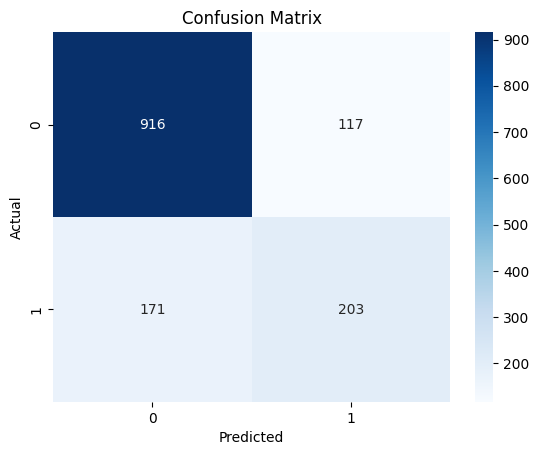

In [22]:
# Define features (X) and target variable (y)
X = df.drop(columns=["Churn","customerID"])
y = df["Churn"].map({"No": 0, "Yes": 1})

# Split the dataset into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Fit the model
logreg = LogisticRegression(max_iter=1000)

# Define hyperparameter grid
param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    "penalty": ["l1", "l2"],  # Type of regularization
    "solver": ["liblinear", "saga"]  # Solvers that support L1/L2 penalty
}

# GridSearchCV
grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,  # 5-Fold Cross Validation
    n_jobs=-1,  # Use all CPU cores
    verbose=1
)

# Fit the model with Grid Search
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Make predictions using the best model
y_pred = best_model.predict(X_test)

# Evaluate model performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Visualize Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


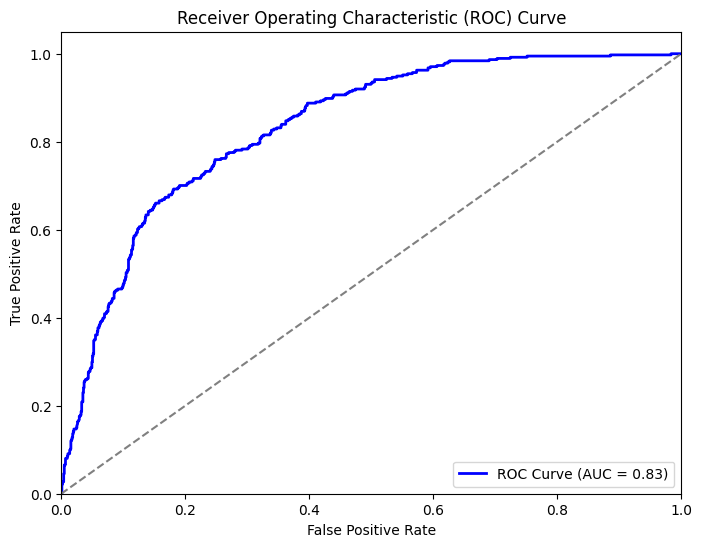

In [23]:
# Get predicted probabilities for positive class (1)
y_probs = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)  # Compute AUC score

# Plot the ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


### Training a KNN model

🔹 Accuracy: 0.7512437810945274

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.84      0.83      1033
           1       0.53      0.52      0.53       374

    accuracy                           0.75      1407
   macro avg       0.68      0.68      0.68      1407
weighted avg       0.75      0.75      0.75      1407


🔹 Confusion Matrix:
 [[863 170]
 [180 194]]


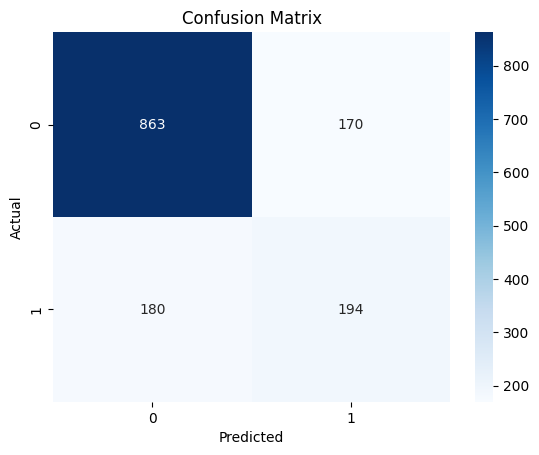

In [24]:
# Define features (X) and target (y)
X = df.drop(columns=["Churn","customerID"])
y = df["Churn"].map({"No": 0, "Yes": 1})

# Split dataset into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()
X_train.iloc[:, :] = scaler.fit_transform(X_train)
X_test.iloc[:, :] = scaler.transform(X_test)

# Train KNN model (using k=5 neighbors)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)

# Evaluate model performance
print("🔹 Accuracy:", accuracy_score(y_test, y_pred))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred))
print("\n🔹 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Visualize Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


🔹 Accuracy: 0.7938877043354655

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1033
           1       0.65      0.49      0.56       374

    accuracy                           0.79      1407
   macro avg       0.74      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407


🔹 Confusion Matrix:
 [[935  98]
 [192 182]]


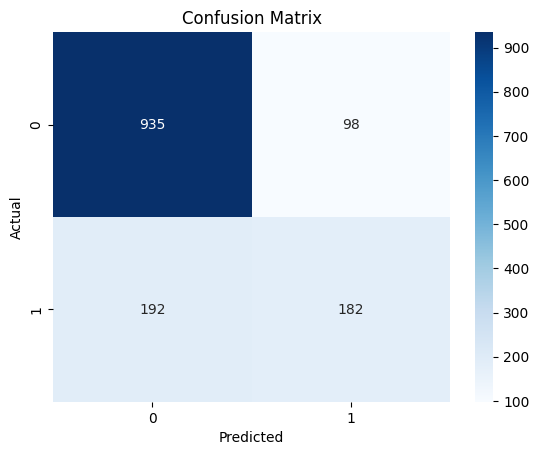

In [25]:
# Define features (X) and target variable (y)
X = df.drop(columns=["Churn","customerID"])
y = df["Churn"].map({"No": 0, "Yes": 1})

# Split dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()
X_train.iloc[:, :] = scaler.fit_transform(X_train)
X_test.iloc[:, :] = scaler.transform(X_test)

# Train SVM model with RBF kernel
svm_model = SVC(kernel="rbf", C=1.0, gamma="scale", random_state=42)
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test)

# Evaluate model performance
print("🔹 Accuracy:", accuracy_score(y_test, y_pred))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred))
print("\n🔹 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Visualize Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


### Training a Ridge Classifier model

🔹 Accuracy: 0.798862828713575

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1033
           1       0.65      0.52      0.58       374

    accuracy                           0.80      1407
   macro avg       0.75      0.71      0.72      1407
weighted avg       0.79      0.80      0.79      1407


🔹 Confusion Matrix:
 [[931 102]
 [181 193]]


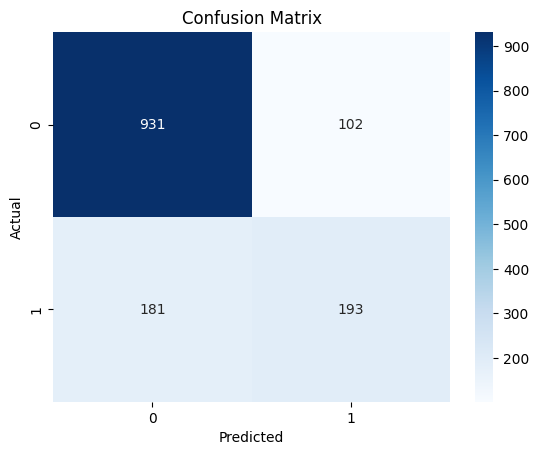

In [26]:
# Define features (X) and target variable (y)
X = df.drop(columns=["Churn","customerID"])
y = df["Churn"].map({"No": 0, "Yes": 1})

# Split dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical features (Ridge Classifier benefits from scaling)
scaler = StandardScaler()
X_train.iloc[:, :] = scaler.fit_transform(X_train)
X_test.iloc[:, :] = scaler.transform(X_test)

# Train Ridge Classifier (L2 Regularization)
ridge_model = RidgeClassifier(alpha=1.0)  # Alpha controls regularization strength
ridge_model.fit(X_train, y_train)

# Make predictions
y_pred = ridge_model.predict(X_test)

# Evaluate model performance
print("🔹 Accuracy:", accuracy_score(y_test, y_pred))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred))
print("\n🔹 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Visualize Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


### Training a Naive Bayes model

🔹 Accuracy: 0.6958066808813077

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.66      0.76      1033
           1       0.46      0.80      0.58       374

    accuracy                           0.70      1407
   macro avg       0.68      0.73      0.67      1407
weighted avg       0.78      0.70      0.71      1407


🔹 Confusion Matrix:
 [[681 352]
 [ 76 298]]


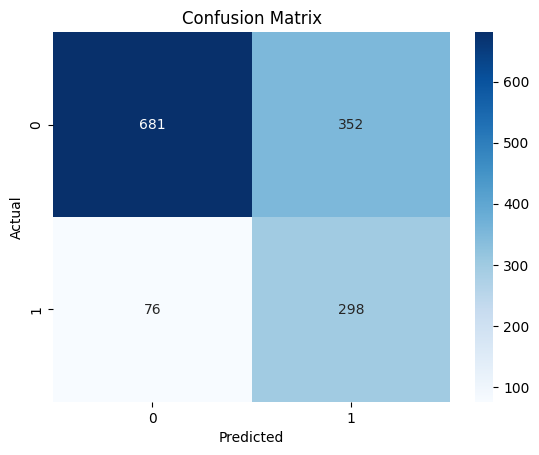

In [27]:
# Define features (X) and target variable (y)
X = df.drop(columns=["Churn","customerID"])
y = df["Churn"].map({"No": 0, "Yes": 1})

# Split dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()
X_train.iloc[:, :] = scaler.fit_transform(X_train)
X_test.iloc[:, :] = scaler.transform(X_test)

# Train Naïve Bayes classifier
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Make predictions
y_pred = nb_model.predict(X_test)

# Evaluate model performance
print("🔹 Accuracy:", accuracy_score(y_test, y_pred))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred))
print("\n🔹 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Visualize Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


### Training a Decision Tree Model

🔹 Accuracy: 0.7818052594171997

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.86      1033
           1       0.61      0.50      0.55       374

    accuracy                           0.78      1407
   macro avg       0.72      0.69      0.70      1407
weighted avg       0.77      0.78      0.77      1407


🔹 Confusion Matrix:
 [[913 120]
 [187 187]]


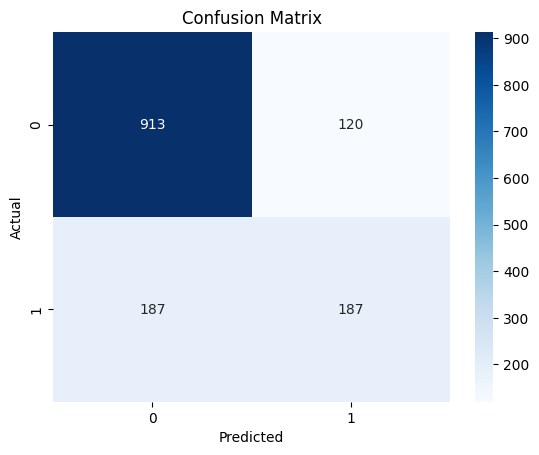

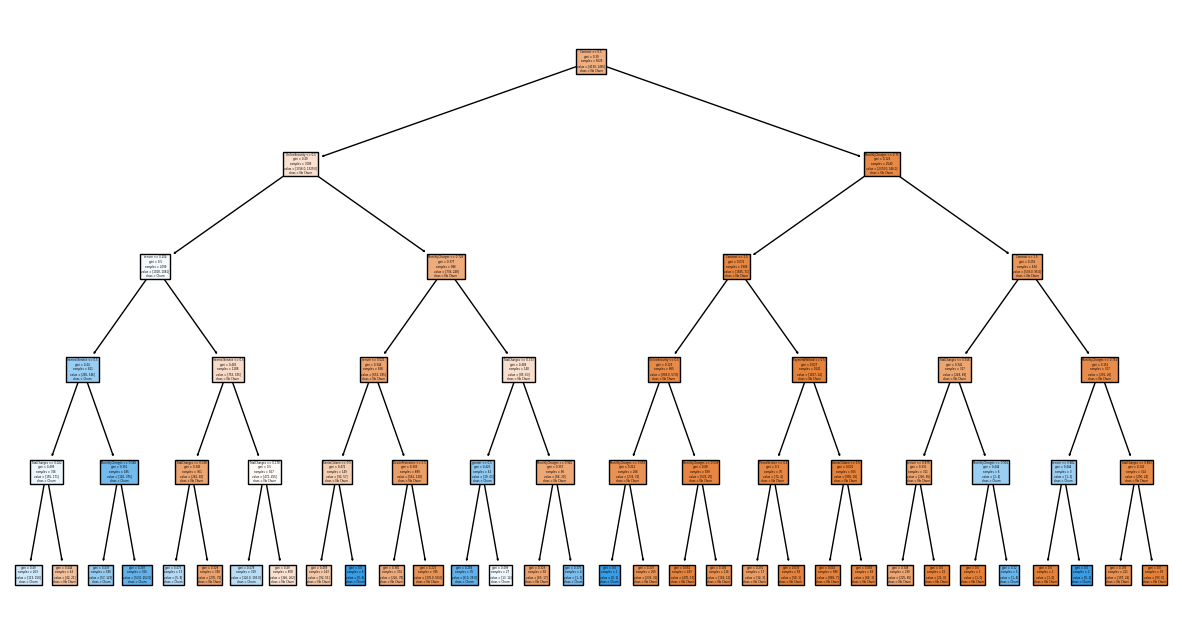

In [28]:
# Define features (X) and target variable (y)
X = df.drop(columns=["Churn","customerID"])
y = df["Churn"].map({"No": 0, "Yes": 1})

# Split dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Decision Tree model
dt_model = DecisionTreeClassifier(criterion="gini", max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

# Make predictions
y_pred = dt_model.predict(X_test)

# Evaluate model performance
print("🔹 Accuracy:", accuracy_score(y_test, y_pred))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred))
print("\n🔹 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Visualize Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Plot Decision Tree
plt.figure(figsize=(15, 8))
tree.plot_tree(dt_model, feature_names=X.columns, class_names=["No Churn", "Churn"], filled=True)
plt.show()


### Training a Random Forest model

🔹 Accuracy: 0.7654584221748401

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.79      0.83      1033
           1       0.55      0.70      0.61       374

    accuracy                           0.77      1407
   macro avg       0.71      0.74      0.72      1407
weighted avg       0.79      0.77      0.77      1407


🔹 Confusion Matrix:
 [[816 217]
 [113 261]]


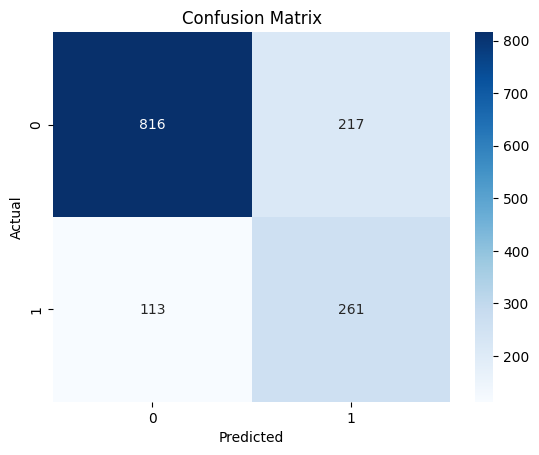

In [29]:
# Define features (X) and target variable (y)
X = df.drop(columns=["Churn","customerID"])
y = df["Churn"].map({"No": 0, "Yes": 1})

# Split dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()
X_train.iloc[:, :] = scaler.fit_transform(X_train)
X_test.iloc[:, :] = scaler.transform(X_test)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate model performance
print("🔹 Accuracy:", accuracy_score(y_test, y_pred))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred))
print("\n🔹 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Visualize Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
